Few key observations
- If both and non-encrypted files are base-32 encoded, accuracy drops really low.
   * Even in this case, fourier analysis (specifically autocorrelation and mean) provide good discrminators
   * Renyi's entropy at alpha=infinity gives good discrimination
   * Overall we see around 13% improvement in F1-score
- Specifically for webpfiles
   * We see that higher moments of around 14 gives a good discrimination
   * Fourier analysis still gives benefits here
- For webpfiles where both unencrypted and encrypted content are base32 encrypted
   * Fourier analysis is still beneficial
- For Non-webp files where plaintext is not base-32 encrypted
   * Accuracy is decent with just the base parameters, but with fourier analysis, we can close to perfect detection


In [14]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import glob

plt.rcParams["figure.figsize"] = (20,20)

In [2]:
!ls

expanded.plaintext.base32.csv.gz
expanded.pyencrypted_v1.b32.csv.gz
expanded.pyencrypted_v1.csv.gz
expanded.pyencrypted_v2.base32.csv.gz
expanded.pyencrypted_v2.csv.gz
iteration_2_compare_base32_alternate_encryption_scheme.ipynb
plaintext.base32.combined.csv.gz
plaintext.combined.csv.gz
plaintext.expanded.csv.gz


In [39]:
all_dfs = []
for filename in glob.glob("*.csv.gz"):
    if filename in ["expanded.plaintext.base32.csv.gz", "plaintext.base32.combined.csv.gz"]:
        continue
    df = pd.read_csv(filename)
    df.sample(frac=1).reset_index(drop=True)
    if "encr" in filename.lower():
        df["is_encrypted"] = 1
    else:
        df["is_encrypted"] = 0
    all_dfs.append(df)

all_dfs = pd.concat(all_dfs)

In [40]:
print("Plaintext: ", all_dfs[all_dfs["is_encrypted"] == 0].shape)
print("Encrypted: ", all_dfs[all_dfs["is_encrypted"] == 1].shape)

Plaintext:  (161706, 677)
Encrypted:  (323412, 677)


In [3]:
master_plain_df = pd.read_csv("expanded.plaintext.base32.csv.gz")
master_encrypt_df = pd.read_csv("expanded.pyencrypted_v2.base32.csv.gz")
master_encrypt_df_nonb32 = pd.read_csv("expanded.pyencrypted_v2.csv.gz")
original_plain_df = pd.read_csv("plaintext.expanded.csv.gz")
encrypted_v1 = pd.read_csv("expanded.pyencrypted_v1.csv.gz")

In [25]:
baseline_columns = [c for c in master_encrypt_df.columns if c.startswith('baseline') and "head" not in c and "tail" not in c]
baseline_columns = [c for c in baseline_columns if "filesize" not in c]
baseline_columns = [c for c in baseline_columns if "begin" not in c and "end" not in c]

In [5]:
master_plain_df = master_plain_df.sample(frac=1).reset_index(drop=True)
master_encrypt_df = master_encrypt_df.sample(frac=1).reset_index(drop=True)
original_plain_df = original_plain_df.sample(frac=1).reset_index(drop=True)
master_encrypt_df_nonb32 = master_encrypt_df_nonb32.sample(frac=1).reset_index(drop=True)
encrypted_v1 = encrypted_v1.sample(frac=1).reset_index(drop=True)

In [6]:
master_plain_df["is_encrypted"] = 0
master_encrypt_df["is_encrypted"] = 1
original_plain_df["is_encrypted"] = 0
master_encrypt_df_nonb32["is_encrypted"] = 1
encrypted_v1["is_encrypted"] = 1

In [30]:
combined_df = pd.concat([master_plain_df, master_encrypt_df, original_plain_df, master_encrypt_df_nonb32])

In [49]:
combined_df = all_dfs

In [50]:
combined_df = combined_df.fillna(0.0)
combined_df = combined_df[combined_df["extended.extension"] != ".webp"]

[0.93274148 0.99530614] [0.99077491 0.96476417] [0.96088275 0.9797972 ] [ 9756 19781]
F1 = 0.9797972018996278




<BarContainer object of 4 artists>

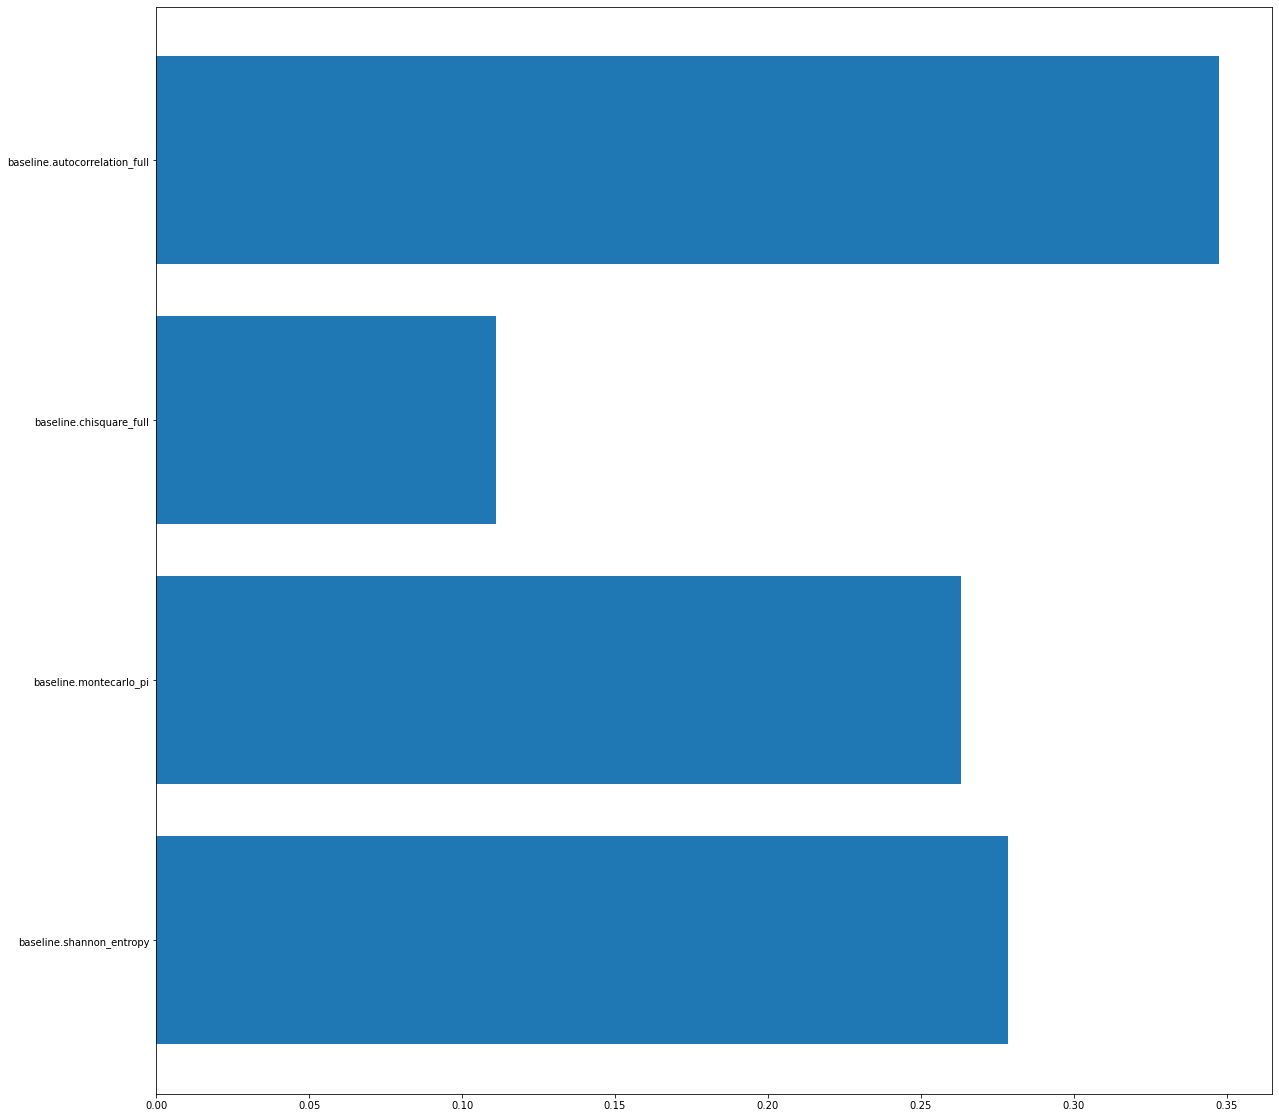

In [51]:
# use basline_columns instead of basic_columns to show what we get from end entropy
basic_columns = [c for c in baseline_columns if "end" not in c]
X, y = combined_df[basic_columns], combined_df["is_encrypted"]
bX_train, bX_test, by_train, by_test = train_test_split(X, y, test_size=0.10, random_state=42)


rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression())]
estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(bX_train, by_train)
by_pred = pipeline.predict(bX_test)
precision, recall, fscore, support = precision_recall_fscore_support(by_test, by_pred)
print(precision, recall, fscore, support)
print(f"F1 = {f1_score(by_test, by_pred)}")
print()
print()
plt.barh(X.columns, rfc.feature_importances_)

In [52]:
extra_columns = [c for c in combined_df.columns if "fourier" in c and "value" not in c]
extra_columns = [c for c in extra_columns if "1byte" in c]
advanced_columns = [c for c in combined_df.columns if "advanced" in c]
advanced_columns = [c for c in advanced_columns if "begin" not in c and "end" not in c]
advanced_columns = [c for c in advanced_columns if "head" not in c and "tail" not in c]
advanced_columns = [c for c in advanced_columns if "start" not in c]

/var/folders/z1/hfz3q2b52bx3hb8nh0z1q89c0000gp/T/ipykernel_42579/2894421426.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["fourier.stat.product"] = X["fourier.stat.1byte.mean"].abs() * X["fourier.stat.1byte.autocorr"].abs()


[0.98943089 0.99898462] [0.99794998 0.99474243] [0.99367218 0.99685901] [ 9756 19781]
F1 = 0.9968590100815643




<BarContainer object of 23 artists>

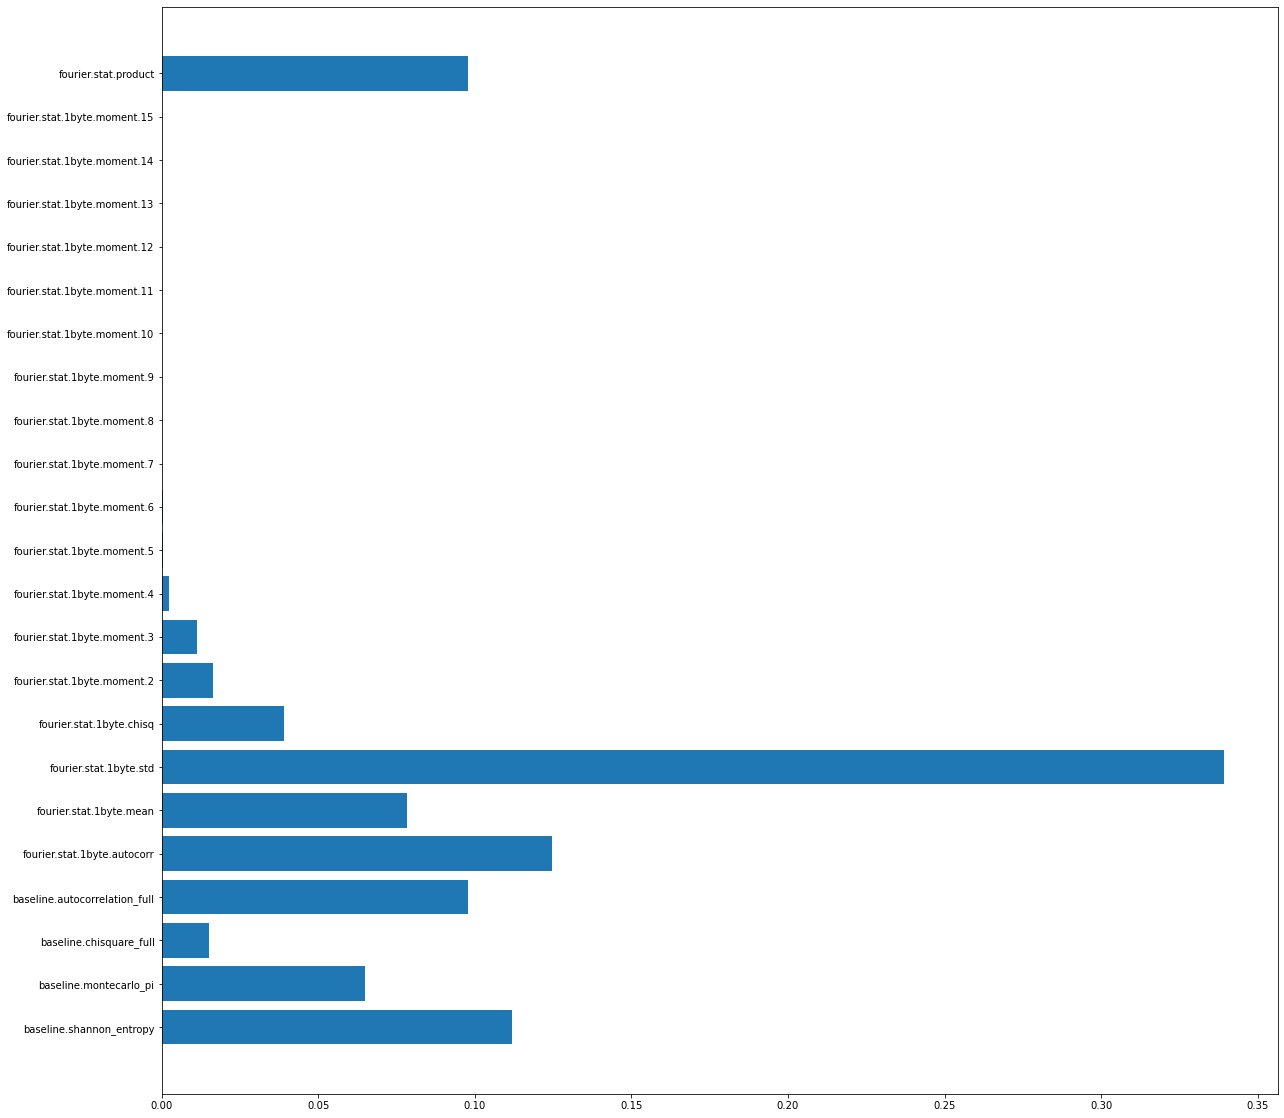

In [53]:
# use basline_columns instead of basic_columns to show what we get from end entropy
basic_columns = [c for c in baseline_columns if "end" not in c]
X, y = combined_df[basic_columns + extra_columns], combined_df["is_encrypted"]
X["fourier.stat.product"] = X["fourier.stat.1byte.mean"].abs() * X["fourier.stat.1byte.autocorr"].abs()
bX_train, bX_test, by_train, by_test = train_test_split(X, y, test_size=0.10, random_state=42)


rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression())]
estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(bX_train, by_train)
by_pred = pipeline.predict(bX_test)
precision, recall, fscore, support = precision_recall_fscore_support(by_test, by_pred)
print(precision, recall, fscore, support)
print(f"F1 = {f1_score(by_test, by_pred)}")
print()
print()
plt.barh(X.columns, rfc.feature_importances_)

/var/folders/z1/hfz3q2b52bx3hb8nh0z1q89c0000gp/T/ipykernel_42579/1494872762.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["fourier.stat.product"] = X["fourier.stat.1byte.mean"].abs() * X["fourier.stat.1byte.autocorr"].abs()


[0.99246129 0.9992901 ] [0.99856499 0.99625904] [0.99550378 0.99777226] [ 9756 19781]
F1 = 0.9977722646954584


<BarContainer object of 64 artists>

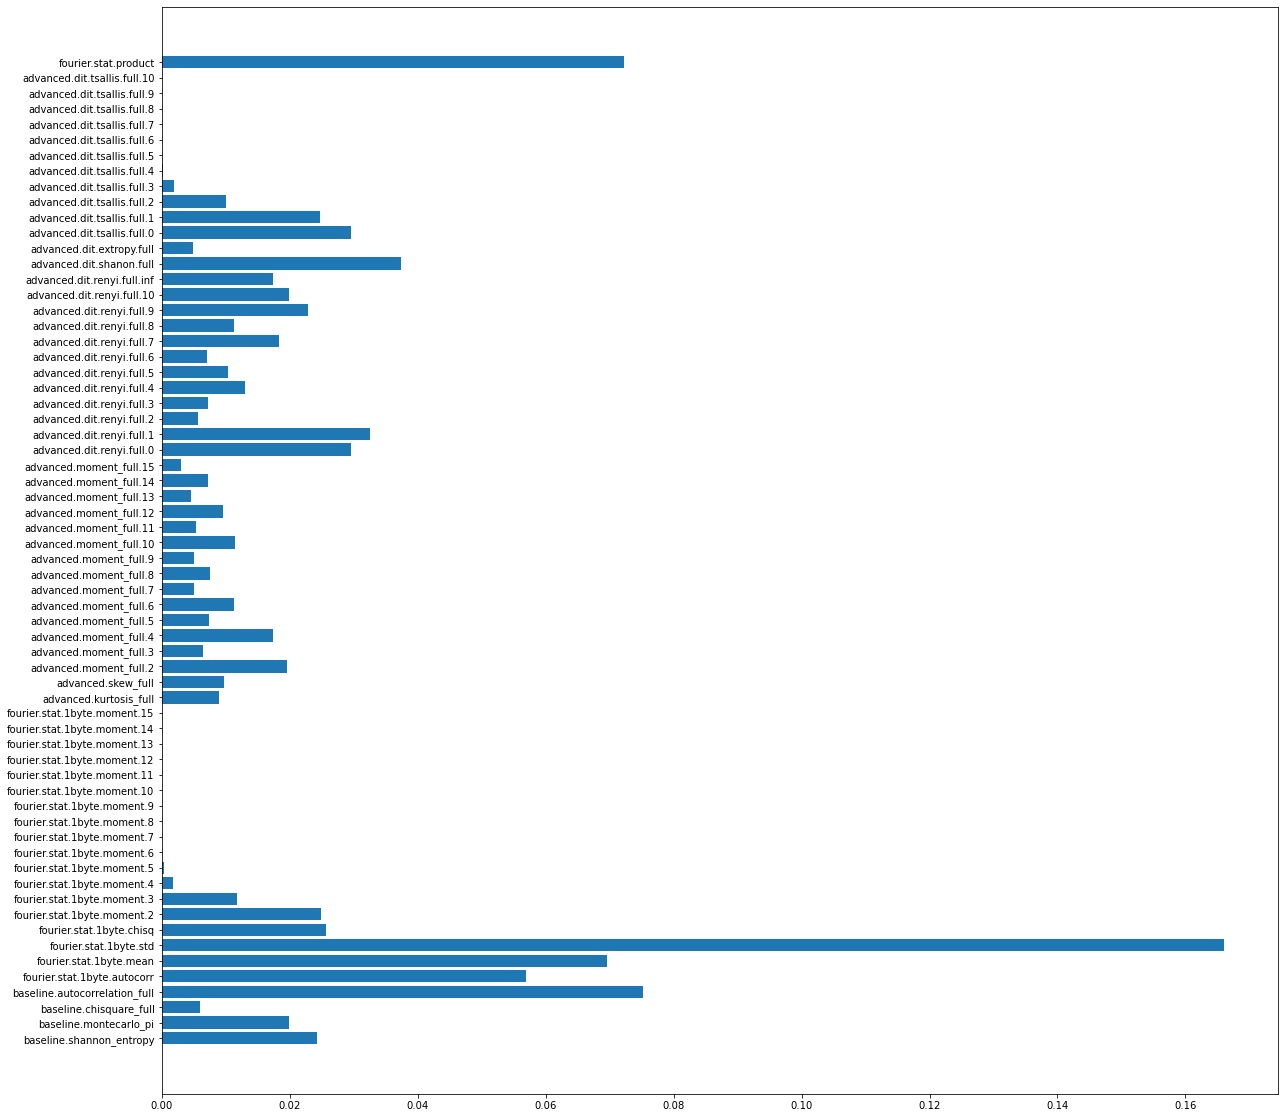

In [54]:
# use basline_columns instead of basic_columns to show what we get from end entropy
basic_columns = [c for c in baseline_columns if "end" not in c]
X, y = combined_df[basic_columns + extra_columns + advanced_columns], combined_df["is_encrypted"]
X["fourier.stat.product"] = X["fourier.stat.1byte.mean"].abs() * X["fourier.stat.1byte.autocorr"].abs()
bX_train, bX_test, by_train, by_test = train_test_split(X, y, test_size=0.10, random_state=42)

rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression())]
estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(bX_train, by_train)
by_pred = pipeline.predict(bX_test)
precision, recall, fscore, support = precision_recall_fscore_support(by_test, by_pred)
print(precision, recall, fscore, support)
print(f"F1 = {f1_score(by_test, by_pred)}")
plt.barh(X.columns, rfc.feature_importances_)